In [ ]:
# Poisson Spike Train Generator
'''





'''



In [2]:
# imports

import numpy as np 
import struct
import matplotlib.pyplot as plt
import csv

from brian2 import *

%matplotlib inline

INFO       Cache size for target "cython": 1469 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\Lei\.cython\brian_extensions" directory. [brian2]


In [3]:
# Read in MNIST training data set

with open("../data/MNIST/train/train-images.idx3-ubyte", 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype = np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))

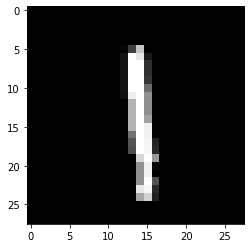

In [12]:
# check MNIST image

plt.imshow(data[8, :, :], cmap = "gray")
plt.show()

In [16]:
with open("../data/MNIST/test/t10k-images.idx3-ubyte", 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype = np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))

In [22]:
len(data)

10000

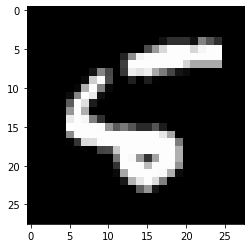

In [36]:
plt.imshow(data[8, :, :], cmap = "gray")
plt.show()

In [35]:
label[8]

5

In [8]:
# generate randomly distributed spike train using fire rate
# !! relatively fast !!

maxRate = 50    #Hz

imageNo = np.arange(len(data))

pst_all = []

for imageIndex in imageNo:
    pst_img = []
    for rowIndex in range(0, len(data[0])):
        for colIndex in range(0, len(data[0][0])):
            pst_img.append(data[imageIndex][rowIndex][colIndex] * maxRate / 255)
    pst_all.append(pst_img)
    if (imageIndex + 1) % 1000 == 0:
        print("Progress: {0:.2f}%".format(100 * (imageIndex + 1) / len(data)))

pst_rate = np.array(pst_all)

Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
Progress: 100.00%


In [9]:
# Write PST file to txt
for batch in range(1):
    with open("pst_test_{0}.txt".format(batch), "w") as f:
        f.write("784 10000\n")
        for row in pst_all[(batch * 10000) : (batch * 10000 + 10000)]:
            for rate in row:
                f.write("{0:.3g} ".format(rate))
            f.write("\n")

In [38]:
# Read MNIST labels

# train/train-labels.idx1-ubyte
# test/t10k-labels.idx1-ubyte


with open("../data/MNIST/train/train-labels.idx1-ubyte", 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    label = np.fromfile(f, dtype = np.dtype(np.uint8).newbyteorder('>'))

In [39]:
# Write labels to txt

with open("train_label.txt", "w") as f:
    for row in range(60000):
        f.write("{0}\n".format(label[row]))

In [137]:
# Parameters for randomly distributed Poisson spike train
# Simulation time [ms]
simT = 100

# Number of Bin (time step)
binN = 10

# Bin period
binT = simT / binN

# Spike probability modifier (max spike per bin [0 ~ 1])
c = 1

# time step
timeStep = np.linspace(0, simT, binN + 1)

In [138]:
# generate randomly distributed Poisson spike train
# !! Very time consuming !!

imageNo = np.arange(3)

pst_all = []

for imageIndex in imageNo:
    pst_img = []
    for t in timeStep:
        pst_time = []
        for rowIndex in range(0, len(data[0])):
            for colIndex in range(0, len(data[0][0])):
                p = data[imageIndex][rowIndex][colIndex] / 255
                rng = uniform(0, 1)
                if p > rng:
                    pst_time.append(1)
                else:
                    pst_time.append(0)
        pst_img.append(pst_time)
    pst_all.append(pst_img)

pst_array = np.array(pst_all)

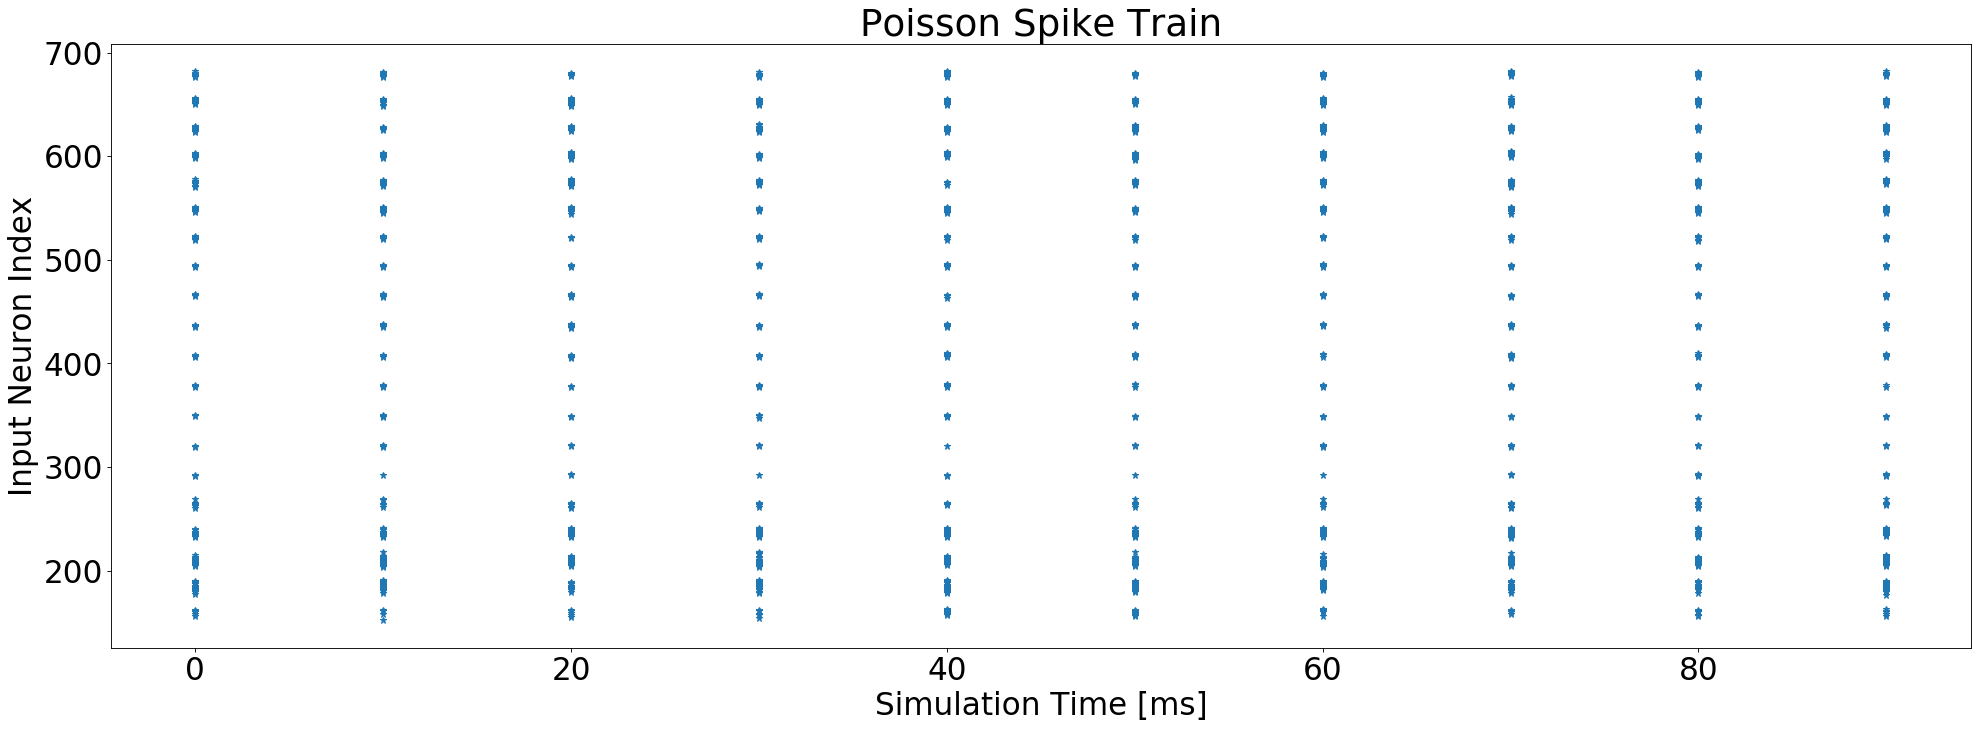

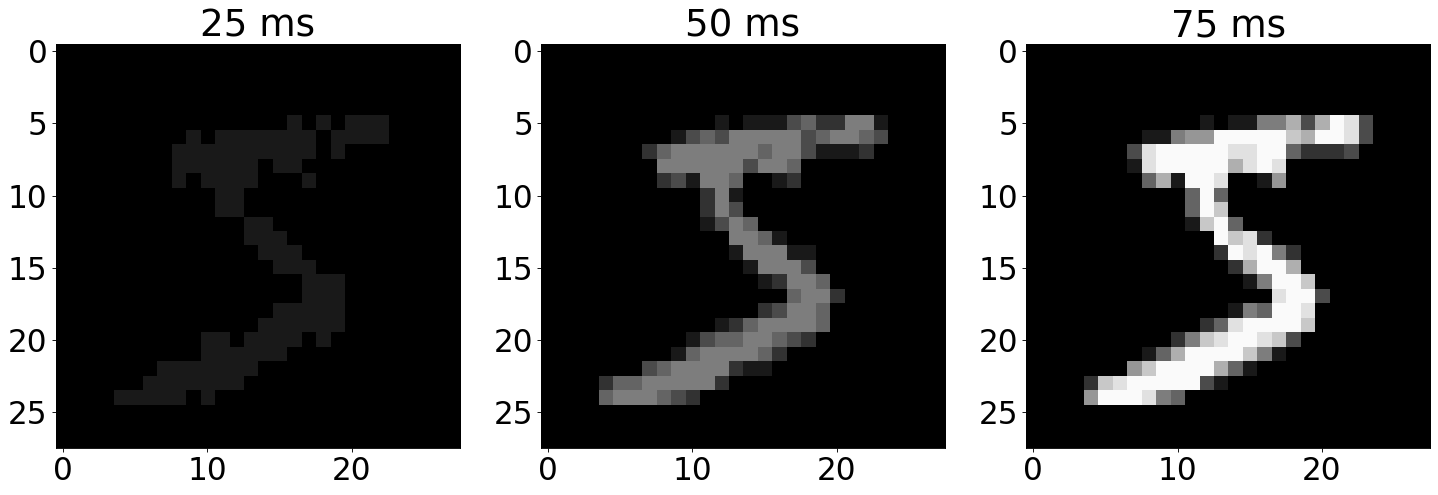

In [167]:
# Illustrator of effect of accumulating Poisson spike signals over time

img_acc = np.zeros((3, len(data[0]), len(data[0][0])))

img250 = np.zeros((len(data[0]), len(data[0][0])))
for t in range(1):
    for x in range(0, len(data[0])):
        for y in range(0, len(data[0][0])):
            img250[x, y] = img250[x, y] + pst_array[0, t, x * len(data[0][0]) + y]

img500 = np.zeros((len(data[0]), len(data[0][0])))
for t in range(5):
    for x in range(0, len(data[0])):
        for y in range(0, len(data[0][0])):
            img500[x, y] = img500[x, y] + pst_array[0, t, x * len(data[0][0]) + y]

img750 = np.zeros((len(data[0]), len(data[0][0])))
for t in range(10):
    for x in range(0, len(data[0])):
        for y in range(0, len(data[0][0])):
            img750[x, y] = img750[x, y] + pst_array[0, t, x * len(data[0][0]) + y]

img250 = img250 * 25
img500 = img500 * 25
img750 = img750 * 25

t = []
n = []

for ti in range(10):
    for ni in range(28*28):
        if pst_array[0][ti][ni] == 1:
            t.append(ti * 10)
            n.append(ni)

plt.figure(figsize = (30, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.plot(t, n, "*")
plt.title("Poisson Spike Train")
plt.xlabel("Simulation Time [ms]")
plt.ylabel("Input Neuron Index")

plt.figure(figsize = (30, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(1,4,2)
plt.title("25 ms")
plt.imshow(img250, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,4,3)
plt.title("50 ms")
plt.imshow(img500, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,4,4)
plt.title("75 ms")
plt.imshow(img750, cmap='gray', vmin=0, vmax=255)

plt.rc("font", size=28)

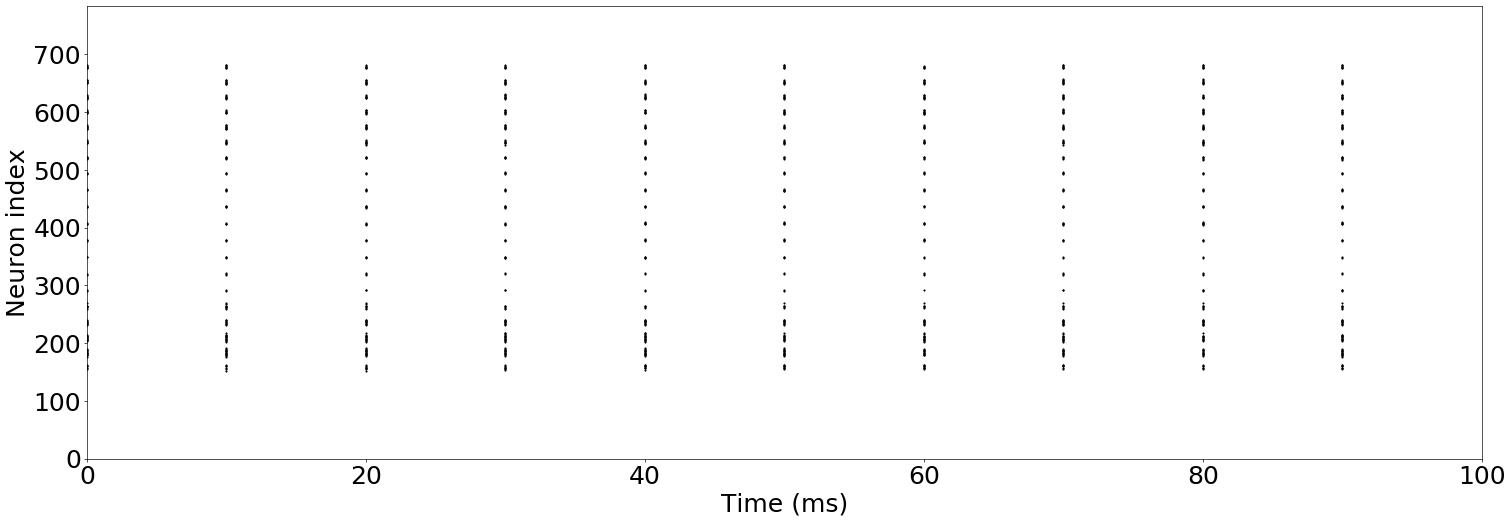

In [214]:
# Brian2 raster representation

start_scope()
num_samples, N = pst_array[0].shape
ta = TimedArray(pst_array[0], dt=10*ms) # 228
A = 100
tau = 1*ms
# eqs = '''
# dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
# '''

eqs = '''
dv/dt = (A*ta(t, i)-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory='10*ms',  method='exact')
M = SpikeMonitor(G)
run(100*ms)
figure(figsize = (30, 10), dpi = 60, facecolor = 'w', edgecolor = 'k')
plot(M.t/ms, M.i, '.k', ms=3)
xlim(0, 100)
ylim(0, N)
xlabel('Time (ms)')
ylabel('Neuron index')

rc("font", size=30)

In [102]:
# Write PST file to csv
# !! Huge file don't use !!
with open("PST_train_rate_CsvVer.csv", "w", newline="") as f:
    wr = csv.writer(f, delimiter=",")
    wr.writerows(pst_all[0:60000])


In [96]:
# Read PST file from csv

pst_in = []
with open("PST_train_rate_CsvVer.csv", "r") as CSVfile:
    rd = csv.reader(CSVfile, delimiter=",")
    for row in rd:
        rate_list = []
        for rate in row:
            rate_list.append(float(rate))
        pst_in.append(rate_list)


In [122]:
# Read PST file from txt
pst_in = []
n_input = 0
n_sample = 0
with open("pst_train_full.txt", "r") as f:
    first_line = f.readline()
    n_input = int(first_line.split()[0])
    n_sample = int(first_line.split()[1])
    for row in f:
        rate_list = []
        for rate in row.split():
            rate_list.append(float(rate))
        pst_in.append(rate_list)

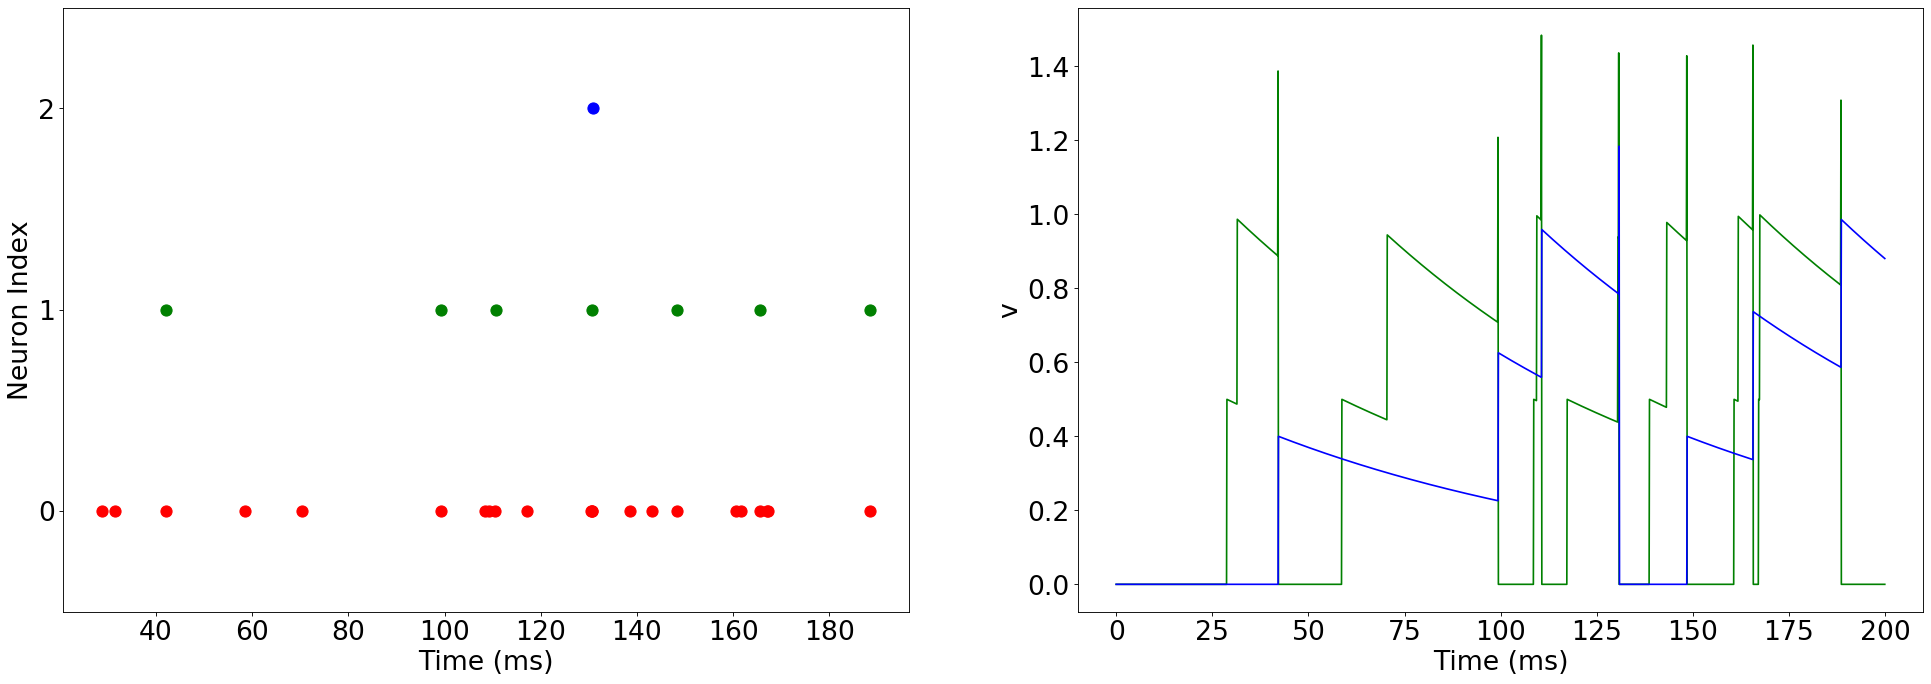

In [141]:
# First PST file
# One neuron each layer
# Forward singly connected

start_scope()

# 3 neuron network
# (input)  -> (intermediate) -> (output)

input_rate = 100*Hz
tau = 100*ms

input_layer = PoissonGroup(1, input_rate)

eqs = '''
dv/dt = -v/tau : 1
'''

all_layers = NeuronGroup(2, eqs, threshold="v>1", refractory="5*ms", reset="v=0", method="exact")

# all_layers = NeuronGroup(2, eqs, threshold="v>1", refractory="0.2*ms", reset="0", method="exact")

inter_layer = all_layers[0]
output_layer = all_layers[1]

input_synapse = Synapses(input_layer, inter_layer, on_pre='v_post += 0.5')
input_synapse.connect()

inter_synapse = Synapses(inter_layer, output_layer, on_pre='v_post += 0.4')
inter_synapse.connect()

input_spikes = SpikeMonitor(input_layer)
inter_spikes = SpikeMonitor(inter_layer)
output_spikes = SpikeMonitor(output_layer)

inter_states = StateMonitor(inter_layer, 'v', record=True)
output_states = StateMonitor(output_layer, 'v', record=True)

run(200*ms)

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spikes.t/ms, input_spikes.i, '.r', ms=20)
plot(inter_spikes.t/ms, inter_spikes.i+1, '.g', ms=20)
plot(output_spikes.t/ms, output_spikes.i+2, '.b', ms=20)
xlabel('Time (ms)')
ylabel('Neuron Index')
ylim([-0.5, 2.5])
yticks([0, 1, 2])

subplot(1,2,2)
plot(inter_states.t/ms, inter_states.v[0], '-g')
plot(output_states.t/ms, output_states.v[0], '-b')
xlabel('Time (ms)')
ylabel('v')

rc("font", size=24)

In [117]:
# Model 2 file preparation

# network specs
#-----------------------------------------
# number of layers
nlayer = 2
# number of neuron for each layer
n = [4, 2]
# total number of non-input neurons
n_tot = np.sum(n[1:])


# input frequencies
# number ofinput neurons
n_input = n[0]
# number of input samples
n_sample = 1

# detailed spike frequency for each input neuron
input_freq = [100, 50, 75, 100]

# neuron info
#------------------------------------------
# decay constant (leak?)
tau = [50, 80] # ms

# spike threshold
theta = [0.5, 0.8]


# synapse info (weight)
#------------------------------------------
# number of synapses
n_s = 4 * 2

# detailed synapses info
s_w = [[[0.3, 0.2],
    [0.5, 0.1],
    [0.3, 0.6],
    [0.2, 0.4]]]

# write input to txt
#------------------------------------------
# Write PST file to txt
# first line has two number: number of input neurons (n_input), number of input samples (n_sample)
# rest (total of n_sample) lines each has n_input numbers: spike frequency for each input neuron

# example:

# 4 1
# 100 50 75 100

with open("./model2/input2.txt", "w") as f:
    f.write("{0} {1}\n".format(n_input, n_sample))
    for sample_index in range(n_sample):
        for freq in input_freq:
            f.write("{0:.3g} ".format(freq))
        f.write("\n")

# Write neuron specs to txt
#------------------------------------------
# first line has only one number: number of layer (nlayer)
# second line has nlayer numbers representing number of neurons for each layer
# the rest lines each has two numbers: tau and theta

# example:

# 2
# 4 2
# 50 0.5
# 80 0.8

with open("./model2/neuron2.txt", "w") as f:
    # write number of layers
    f.write("{0}\n".format(nlayer))
    # write number of neuron for each layer
    for n_neuron in n:
        f.write("{0} ".format(n_neuron))
    f.write("\n")
    for neuron_index in range(n_tot):
        f.write("{0:.3g} {1:.3g}\n".format(tau[neuron_index], theta[neuron_index]))

# write synapse info
#--------------------------------------------
# first line has one number: number of synapses
# rest line each has three numbers: pre-synaptic neuron index, post-synaptic neuron index, weight

# example:

# 8
# 0 4 0.3
# 0 5 0.2
# 1 4 0.5
# 1 5 0.1
# 2 4 0.3
# 2 5 0.6
# 3 4 0.2
# 3 5 0.4

with open("./model2/synapse2.txt", "w") as f:
    f.write("{0}\n".format(n_s))
    for pre_neuron in range(n[0]):
        for post_neuron in range(n[1]):
            f.write("{0} {1} {2:.3g}\n".format(pre_neuron, post_neuron + np.sum(n[:1]), s_w[0][pre_neuron][post_neuron]))

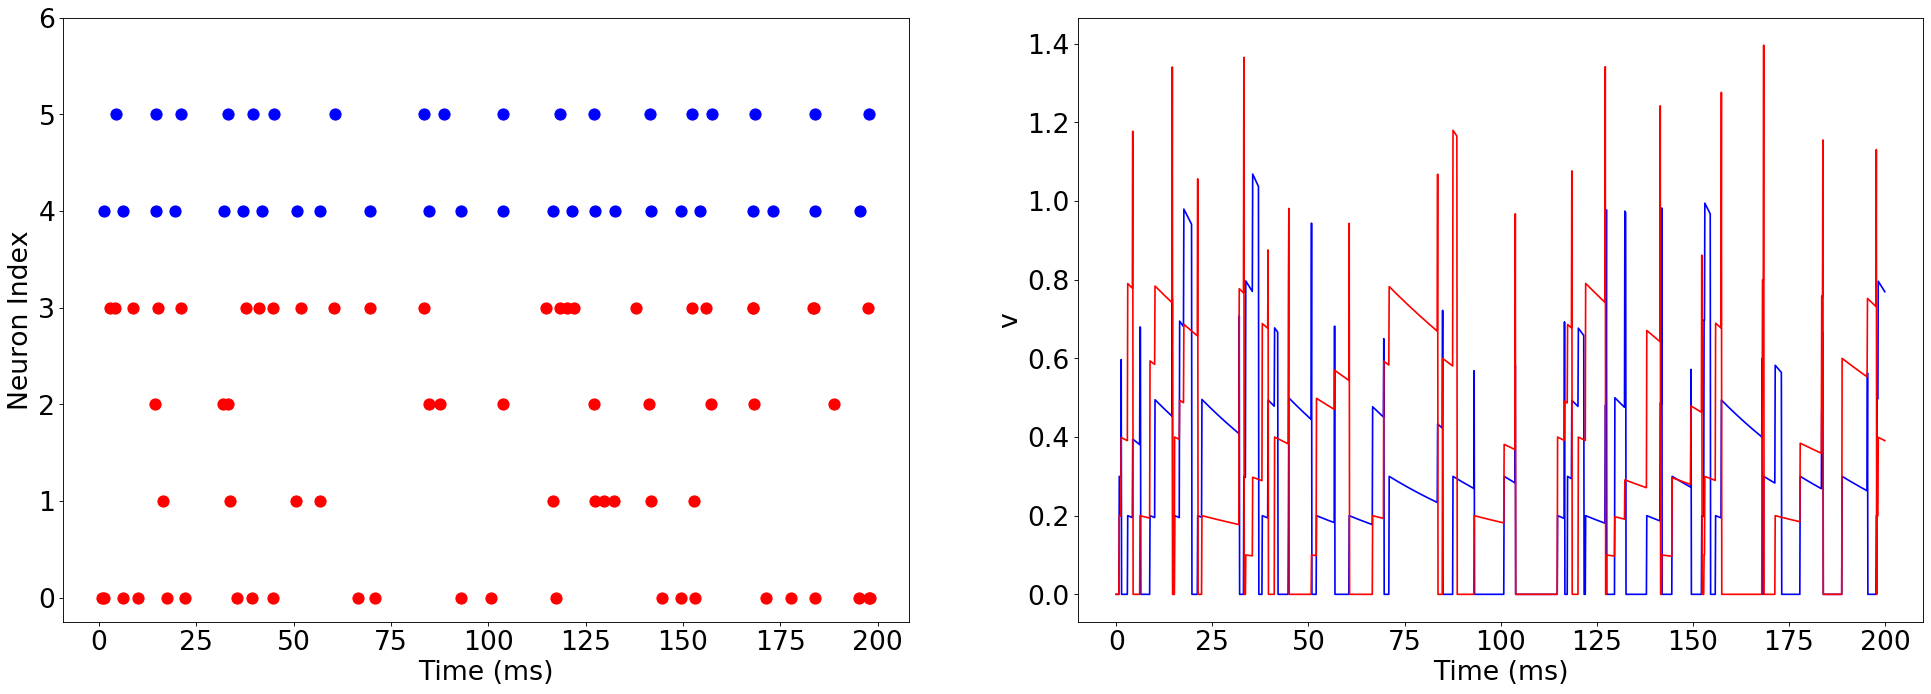

In [24]:
# Model 2 simulation
start_scope()

input_rate = input_freq*Hz

input_layer = PoissonGroup(n_input, input_rate)

eqs = '''
dv/dt = -v/tau : 1
tau : second
theta : 1
'''

output_layer = NeuronGroup(n_tot, eqs, threshold="v>theta", reset="v=0", refractory="5*ms", method = "exact")
output_layer.theta = theta
output_layer.tau = tau*ms

input_synapse = Synapses(input_layer, output_layer, "w : 1", on_pre="v_post += w")
input_synapse.connect()
for source_index in range(n[0]):
    for dest_index in range(n[1]):
        input_synapse.w[source_index, dest_index]=s_w[0][source_index][dest_index]

input_spikes = SpikeMonitor(input_layer)
output_spikes = SpikeMonitor(output_layer)

output_states = StateMonitor(output_layer, 'v', record=True)

run(200*ms)

figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spikes.t/ms, input_spikes.i, '.r', ms=20)
plot(output_spikes.t/ms, output_spikes.i + n_input, '.b', ms=20)
xlabel('Time (ms)')
ylabel('Neuron Index')
yticks([0, 1, 2, 3, 4, 5, 6])

subplot(1,2,2)
plot(output_states.t/ms, output_states.v[0], '-b')
plot(output_states.t/ms, output_states.v[1], '-r')
xlabel('Time (ms)')
ylabel('v')

rc("font", size=24)

In [118]:
# Model 3 file preparation

c_inh = -0.5

# number of neuron layers
n_layer = 3

# number of neurons for each layers
n = [9, 5, 5]

# number of non-input neurons
n_tot = np.sum(n[1:])

# number of input neurons
n_input = n[0]
n_sample = 1

# number of synapse
n_s = n[0] * n[1] + n[1] * n[2]

# input info
input_freq = np.zeros(n_input)
for x in range(len(input_freq)):
    input_freq[x] = uniform(0, 1) * 100

# neuron info
tau = np.zeros(n_tot)
for x in range(len(tau)):
    tau[x] = uniform(0, 1) * 100

theta = np.zeros(n_tot)
for x in range(len(theta)):
    theta[x] = uniform(0, 1)

# synapse info
s_w = []

# synapse from input (0th) layer to 1st layer (one to all)
s_new = np.zeros((n[0], n[1]))
for src_index in range(n[0]):
    for dst_index in range(n[1]):
        s_new[src_index][dst_index] = uniform(0, 1)
s_w.append(s_new)

# synapse from 1st layer to 2nd layer (one to one)
s_new = np.zeros((n[1]))
for src_index in range(n[1]):
    s_new[src_index] = uniform(0, 1)
s_w.append(s_new)

# synapse from 2nd layer to 1st layer (one to other) negative
s_new = np.zeros((n[2], n[1]))
for src_index in range(n[2]):
    for dst_index in range(n[1]):
        if (src_index != dst_index):
            s_new[src_index][dst_index] = c_inh * uniform(0, 1)
s_w.append(s_new)



# write input file
with open("./model3/input3.txt", "w") as f:
    f.write("{0} {1}\n".format(n_input, n_sample))
    for sample_index in range(n_sample):
        for freq in input_freq:
            f.write("{0:.3g} ".format(freq))
        f.write("\n")

# write neuron file
with open("./model3/neuron3.txt", "w") as f:
    # write number of layers
    f.write("{0}\n".format(n_layer))
    # write number of neuron for each layer
    for n_neuron in n:
        f.write("{0} ".format(n_neuron))
    f.write("\n")
    for neuron_index in range(n_tot):
        f.write("{0:.3g} {1:.3g}\n".format(tau[neuron_index], theta[neuron_index]))

# write synapse file
with open("./model3/synapse3.txt", "w") as f:
    f.write("{0}\n".format(n_s))

    # from input to 1st
    for pre_neuron in range(n[0]):
        for post_neuron in range(n[1]):
            f.write("{0} {1} {2:.3g}\n".format(pre_neuron, post_neuron + np.sum(n[:1]), s_w[0][pre_neuron][post_neuron]))

    # from 1st to 2nd
    for pre_neuron in range(n[1]):
        post_neuron = pre_neuron
        f.write("{0} {1} {2:.3g}\n".format(pre_neuron + np.sum(n[:1]), post_neuron + np.sum(n[:2]), s_w[1][pre_neuron]))

    # from 2nd to 1st
    for pre_neuron in range(n[2]):
        for post_neuron in range(n[1]):
            if (pre_neuron != post_neuron):
                f.write("{0} {1} {2:.3g}\n".format(pre_neuron + np.sum(n[:2]), post_neuron + np.sum(n[:1]), s_w[2][pre_neuron][post_neuron]))

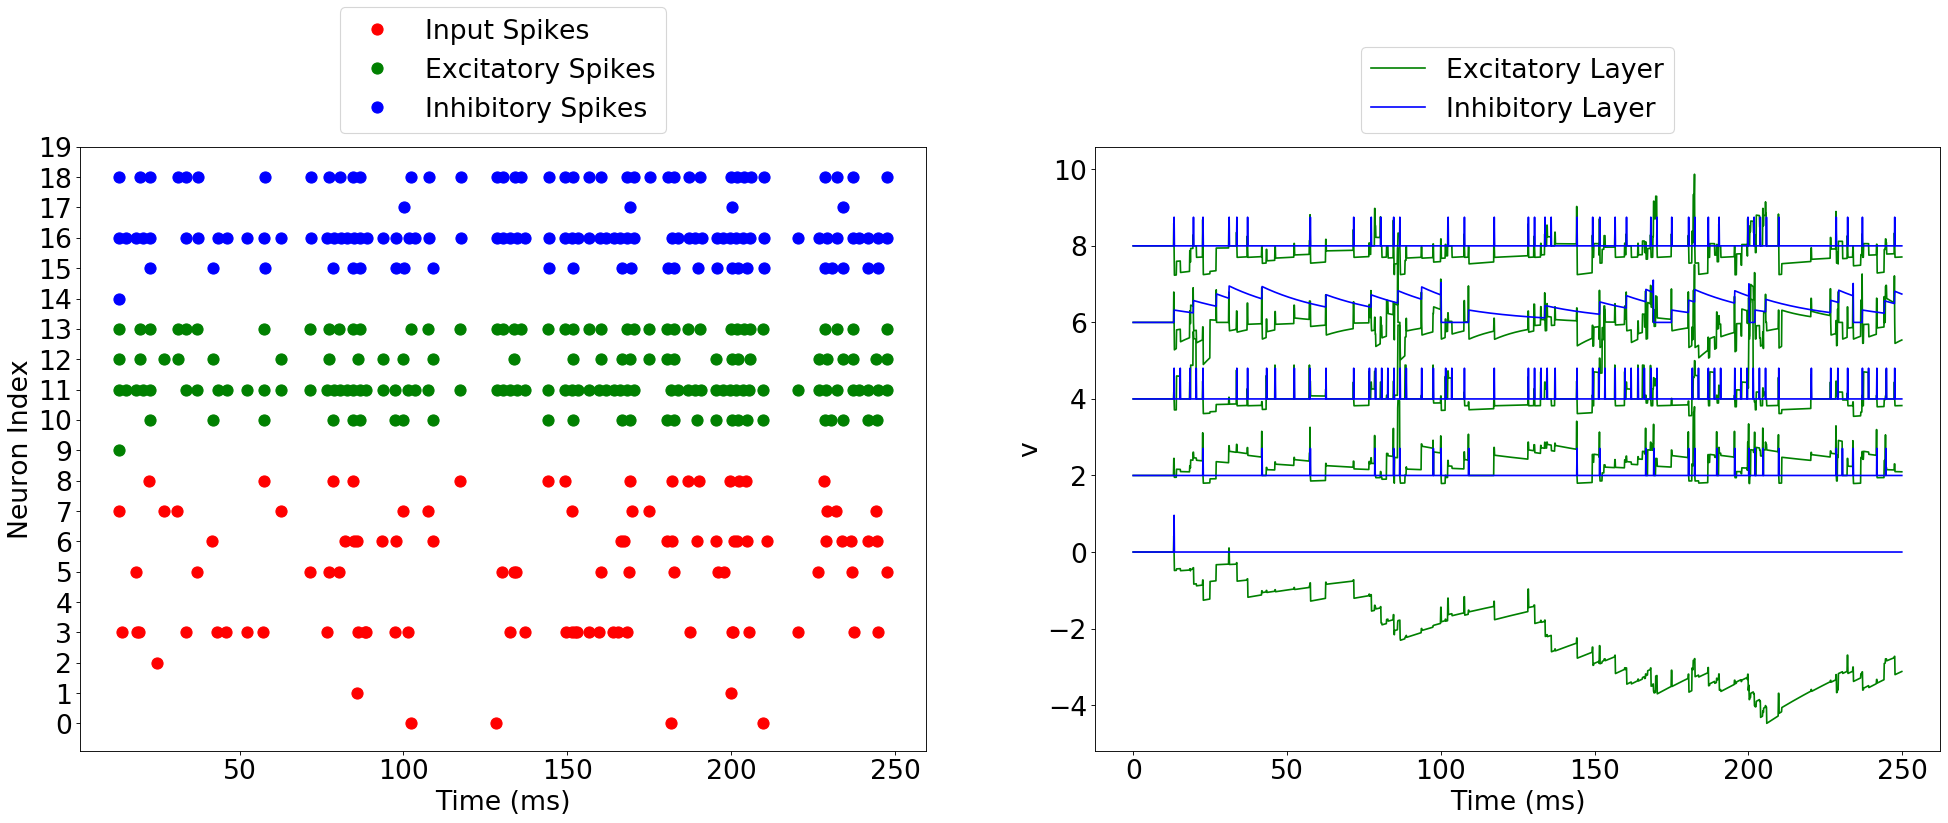

In [116]:
# Model 3 simulation
start_scope()
# create input source

fire_rate = input_freq*Hz

input_layer = PoissonGroup(n_input, fire_rate)

exc_eq = '''
dv/dt=-v/tau : 1
tau : second
theta : 1
'''

inh_eq = '''
dv/dt=-v/tau : 1
tau : second
theta : 1
'''


#create excitatory layer
exc_layer = NeuronGroup(n[1], exc_eq, threshold="v>theta", reset="v=0", refractory="2*ms", method="exact")
exc_layer.tau = tau[:n[1]]*ms
exc_layer.theta = theta[:n[1]]


# create inhibitory layer
inh_layer = NeuronGroup(n[2], inh_eq, threshold="v>theta", reset="v=0", refractory="2*ms", method="exact")
inh_layer.tau = tau[n[1]:np.sum(n[:2])]*ms
inh_layer.theta = theta[n[1]:np.sum(n[:2])]

# create synapses
input_synapse = Synapses(input_layer, exc_layer, "w : 1", on_pre = "v_post += w")
input_synapse.connect()
for src_index in range(n[0]):
    for dst_index in range(n[1]):
        input_synapse.w[src_index, dst_index] = s_w[0][src_index][dst_index]

exc_synapse = Synapses(exc_layer, inh_layer, "w : 1", on_pre = "v_post += w")
exc_synapse.connect(condition = "i == j")
for src_index in range(n[1]):
    exc_synapse.w[src_index, src_index] = s_w[1][src_index]

inh_synapse = Synapses(inh_layer, exc_layer, "w : 1", on_pre = "v_post += w")
inh_synapse.connect(condition = "i != j")
for src_index in range(n[2]):
    for dst_index in range(n[1]):
        if (src_index != dst_index):
            inh_synapse.w[src_index, dst_index] = s_w[2][src_index][dst_index]

input_spikes = SpikeMonitor(input_layer)
exc_spikes = SpikeMonitor(exc_layer)
inh_spikes = SpikeMonitor(inh_layer)

exc_states = StateMonitor(exc_layer, 'v', record=True)
inh_states = StateMonitor(inh_layer, 'v', record=True)

run(250*ms)


figure(figsize = (30, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
subplot(1,2,1)
plot(input_spikes.t/ms, input_spikes.i, '.r', ms=20)
plot(exc_spikes.t/ms, exc_spikes.i + n[0], '.g', ms=20)
plot(inh_spikes.t/ms, inh_spikes.i + np.sum(n[:2]), '.b', ms=20)

legend(("Input Spikes", "Excitatory Spikes", "Inhibitory Spikes"), loc="lower center", bbox_to_anchor=(0.5, 1))
xlabel('Time (ms)')
ylabel('Neuron Index')
yticks(np.arange(20))

subplot(1,2,2)

plot(exc_states.t/ms, exc_states.v[0], '-g', label="Excitatory Layer")
plot(exc_states.t/ms, exc_states.v[1]+2, '-g')
plot(exc_states.t/ms, exc_states.v[2]+4, '-g')
plot(exc_states.t/ms, exc_states.v[3]+6, '-g')
plot(exc_states.t/ms, exc_states.v[4]+8, '-g')

plot(inh_states.t/ms, inh_states.v[0], '-b', label="Inhibitory Layer")
plot(inh_states.t/ms, inh_states.v[1]+2, '-b')
plot(inh_states.t/ms, inh_states.v[2]+4, '-b')
plot(inh_states.t/ms, inh_states.v[3]+6, '-b')
plot(inh_states.t/ms, inh_states.v[4]+8, '-b')

legend(loc="lower center", bbox_to_anchor=(0.5, 1))
xlabel('Time (ms)')
ylabel('v')

rc("font", size=24)